# Model Training – Fraud Detection

This notebook trains and evaluates machine learning models to detect fraudulent transactions using the processed datasets from transform.ipynb. The goal is to test multiple classification models, optimize their performance, and identify the one that best detects rare fraud cases.

**Objectives:**
- Confirm the task type (binary classification) and load the balanced datasets (Random Oversampling and SMOTE)

- Split the data into training and testing sets.

- Train and evaluate three machine learning models:

    - Logistic Regression
    - Random Forest
    - Gradient Boosting 

- Use GridSearchCV or RandomizedSearchCV to tune hyperparameters for each model

- Compare models using accuracy, precision, recall, F1-score, and sensitivity to fraud cases.

- Select the best-performing model to use in future predictions.

## Defining Models

This project is framed as a classification task, not a regression task, because the goal is to predict whether a transaction is fraudulent (1) or not (0), rather than estimate a continuous value like transaction amount.

The target variable isFraud contains only two possible outcomes, meaning this is a binary classification problem, not a multi-class task.

Three machine learning models will be applied to capture a range of complexity and performance:

- **Logistic Regression:** A fast, interpretable linear model that establishes a baseline by finding the best linear boundary to separate fraudulent and non-fraudulent transactions.

- **Random Forest Classifier:** An ensemble of decision trees that captures complex, non-linear relationships, is less sensitive to scaling, and can rank features by importance.

- **Gradient Boosting Classifier:** A boosting method that builds trees sequentially, each correcting the errors of the previous, often achieving strong predictive performance on imbalanced datasets.

Each model will be trained and evaluated on both the Random Oversampling dataset and the SMOTE-balanced dataset to compare their effectiveness under different resampling strategies.

In [27]:
# General libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier






## Load Data 

In [28]:
# Use forward slashes for cross-platform paths
random_path = ('../data/processed_data/transactions_balanced_random.csv')
smote_path = ('../data/processed_data/transactions_balanced_smote.csv')

# Load both datasets
balanced_random = pd.read_csv(random_path)
balanced_smote = pd.read_csv(smote_path)

print("Datasets loaded successfully:")
print(f"- Random Oversampled: {balanced_random.shape}")
print(f"- SMOTE Oversampled: {balanced_smote.shape}")


Datasets loaded successfully:
- Random Oversampled: (1997406, 13)
- SMOTE Oversampled: (1997406, 12)


## Train/Test Split and Feature Scaling
Before training the models, the dataset is split into training (80%) and testing (20%) sets, ensuring that model evaluation is done on unseen data. After splitting, features are scaled using StandardScaler, which standardizes each feature to have a mean of 0 and a standard deviation of 1.

Scaling is done:

- Only on the training data (fit step) to avoid data leakage.

- Applied to the test data (transform step) using the same scaler.

This ensures that models sensitive to feature magnitude (like Logistic Regression and Gradient Boosting) perform correctly. Random Forest, which is scale-invariant, can still benefit from standardized inputs for consistency.

Separate splits and scalers are used for:

- The Random Oversampled dataset

- The SMOTE-balanced dataset

so each resampled version is prepared independently for modeling.

**Splitting**

In [29]:
# Separate features (X) and target (y) for both datasets
def split_features_and_target(df, target_col='isFraud'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

X_random, y_random = split_features_and_target(balanced_random)
X_smote, y_smote = split_features_and_target(balanced_smote)

# Train-Test Split 
def create_train_test_splits(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

X_train_random, X_test_random, y_train_random, y_test_random = create_train_test_splits(X_random, y_random)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = create_train_test_splits(X_smote, y_smote)

# Display the splits 
print("Random Oversampling:", f"Train set: {X_train_random.shape}, Test set: {X_test_random.shape}")

print("SMOTE Oversampling:", f"Train set: {X_train_smote.shape}, Test set: {X_test_smote.shape}")


Random Oversampling: Train set: (1597924, 12), Test set: (399482, 12)
SMOTE Oversampling: Train set: (1597924, 11), Test set: (399482, 11)


**Scaling**

In [30]:
# Drop any non-numeric columns before scaling 
X_train_random_num = X_train_random.select_dtypes(include=['number'])
X_test_random_num = X_test_random.select_dtypes(include=['number'])

X_train_smote_num = X_train_smote.select_dtypes(include=['number'])
X_test_smote_num = X_test_smote.select_dtypes(include=['number'])

# Initialize scalers for each dataset
scaler_random = StandardScaler()
scaler_smote = StandardScaler()

# Fit on training data, transform train and test sets (numeric columns only)
X_train_random_scaled = scaler_random.fit_transform(X_train_random_num)
X_test_random_scaled = scaler_random.transform(X_test_random_num)

X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote_num)
X_test_smote_scaled = scaler_smote.transform(X_test_smote_num)

# Convert to DataFrames for readability (optional)
X_train_random_scaled = pd.DataFrame(X_train_random_scaled, columns=X_train_random_num.columns, index=X_train_random_num.index)
X_test_random_scaled = pd.DataFrame(X_test_random_scaled, columns=X_test_random_num.columns, index=X_test_random_num.index)

X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled, columns=X_train_smote_num.columns, index=X_train_smote_num.index)
X_test_smote_scaled = pd.DataFrame(X_test_smote_scaled, columns=X_test_smote_num.columns, index=X_test_smote_num.index)

# Confirm scaled shapes
print("Scaled Random Dataset:", f"Train set: {X_train_random_scaled.shape}, Test set: {X_test_random_scaled.shape}")
print("Scaled SMOTE Dataset:", f"Train set: {X_train_smote_scaled.shape}, Test set: {X_test_smote_scaled.shape}")


Scaled Random Dataset: Train set: (1597924, 6), Test set: (399482, 6)
Scaled SMOTE Dataset: Train set: (1597924, 6), Test set: (399482, 6)


In [31]:
# Identify dummy (categorical) columns
dummy_cols_random = X_train_random.drop(columns=X_train_random_num.columns).columns
dummy_cols_smote = X_train_smote.drop(columns=X_train_smote_num.columns).columns

# Keep the dummy columns as-is
X_train_random_dummy = X_train_random[dummy_cols_random]
X_test_random_dummy = X_test_random[dummy_cols_random]

X_train_smote_dummy = X_train_smote[dummy_cols_smote]
X_test_smote_dummy = X_test_smote[dummy_cols_smote]

# Combine scaled numeric features with dummy variables
X_train_random_final = pd.concat([X_train_random_scaled, X_train_random_dummy], axis=1)
X_test_random_final = pd.concat([X_test_random_scaled, X_test_random_dummy], axis=1)

X_train_smote_final = pd.concat([X_train_smote_scaled, X_train_smote_dummy], axis=1)
X_test_smote_final = pd.concat([X_test_smote_scaled, X_test_smote_dummy], axis=1)

# Confirm final shapes
print("Final Random Dataset:", f"Train set: {X_train_random_final.shape}, Test set: {X_test_random_final.shape}")
print("Final SMOTE Dataset:", f"Train set: {X_train_smote_final.shape}, Test set: {X_test_smote_final.shape}")


Final Random Dataset: Train set: (1597924, 12), Test set: (399482, 12)
Final SMOTE Dataset: Train set: (1597924, 11), Test set: (399482, 11)


The dataset contains both numeric features (transaction amounts, balances, and engineered ratios) and categorical features (dummy variables representing transaction types and type-size combinations). Scaling all features together caused errors and distorted the dummy variables (since scaling would convert the 0/1 indicators into continuous values).

To address this:

- Numeric features were scaled using StandardScaler to ensure all continuous values share a consistent scale for the machine learning models.

- Categorical features (dummy variables) were kept as-is to preserve their 0/1 representation.

- After scaling, the two sets were concatenated back together to form the final training and testing datasets.

This approach avoids conversion errors (such as attempting to scale string IDs like account names) and ensures that both types of features remain usable for the models.

The final datasets now include both scaled numeric values and intact dummy variables, making them ready for model training.

In [32]:
# Check which columns are currently in X_train and X_test for both datasets
print("Random Oversampling Columns:")
print(X_train_random_final.columns.tolist())

print("\nSMOTE Oversampling Columns:")
print(X_train_smote_final.columns.tolist())


Random Oversampling Columns:
['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'nameDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

SMOTE Oversampling Columns:
['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']


In [33]:
# Drop non-numeric columns like 'nameDest' (only exists in Random Oversampling)
id_cols = ['nameDest']

X_train_random_final = X_train_random_final.drop(columns=id_cols, errors='ignore')
X_test_random_final = X_test_random_final.drop(columns=id_cols, errors='ignore')

# SMOTE dataset has no 'nameDest', so no action needed

print("After cleanup:")
print(f"Random Oversampling (train): {X_train_random_final.shape}")
print(f"Random Oversampling (test): {X_test_random_final.shape}")
print(f"SMOTE (train): {X_train_smote_final.shape}")
print(f"SMOTE (test): {X_test_smote_final.shape}")


After cleanup:
Random Oversampling (train): (1597924, 11)
Random Oversampling (test): (399482, 11)
SMOTE (train): (1597924, 11)
SMOTE (test): (399482, 11)


## Logistic Regression

Hyperparamter Tunning 

In [34]:
lr = LogisticRegression(max_iter=1000, solver='lbfgs')

# Grid of hyperparameters
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],   # Regularization strength
    'penalty': ['l2']          # l2 regularization (lbfgs supports only l2)
}

# GridSearchCV setup
grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='f1',     # F1 balances precision and recall
    cv=3
)

# Fit using Random Oversampling dataset
grid_lr.fit(X_train_random_final, y_train_random)

# Show best hyperparameters
print("Best Parameters (Logistic Regression – Random Oversampling):", grid_lr.best_params_)
best_lr_params = grid_lr.best_params_

Best Parameters (Logistic Regression – Random Oversampling): {'C': 10, 'penalty': 'l2'}


Train Model & Eval


--- Logistic Regression (Random Oversampling) ---
Accuracy: 0.9697933824302472
Precision: 0.9519956070633797
Recall: 0.9894813783850086
F1 Score: 0.9703766076588265


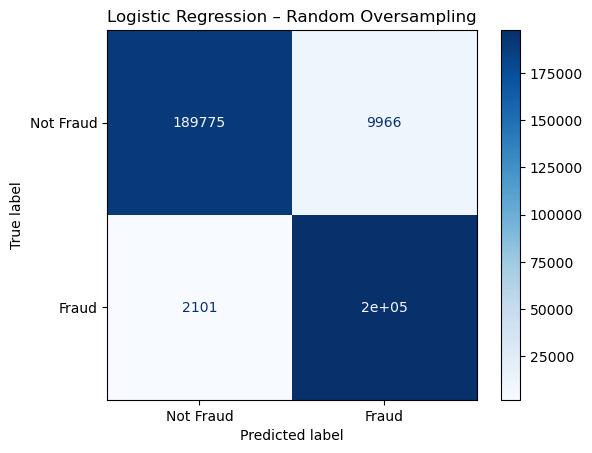


--- Logistic Regression (SMOTE Oversampling) ---
Accuracy: 0.9745195027560691
Precision: 0.9597091805059754
Recall: 0.9906278630826921
F1 Score: 0.9749234449407145


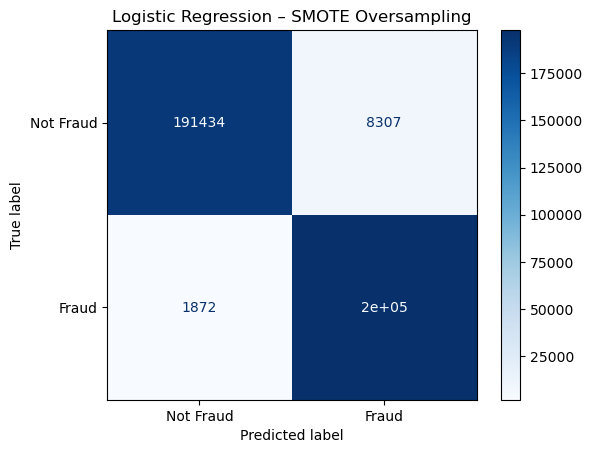

In [35]:
# Create final Logistic Regression model using best params
best_lr_model = LogisticRegression(**best_lr_params, max_iter=1000, solver='lbfgs')

# Evaluate on Random Oversampling 
best_lr_model.fit(X_train_random_final, y_train_random)
y_pred_random = best_lr_model.predict(X_test_random_final)

print("\n--- Logistic Regression (Random Oversampling) ---")
print("Accuracy:", accuracy_score(y_test_random, y_pred_random))
print("Precision:", precision_score(y_test_random, y_pred_random))
print("Recall:", recall_score(y_test_random, y_pred_random))
print("F1 Score:", f1_score(y_test_random, y_pred_random))

cm_random = confusion_matrix(y_test_random, y_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression – Random Oversampling")
plt.show()

# Evaluate on SMOTE Oversampling
best_lr_model.fit(X_train_smote_final, y_train_smote)
y_pred_smote = best_lr_model.predict(X_test_smote_final)

print("\n--- Logistic Regression (SMOTE Oversampling) ---")
print("Accuracy:", accuracy_score(y_test_smote, y_pred_smote))
print("Precision:", precision_score(y_test_smote, y_pred_smote))
print("Recall:", recall_score(y_test_smote, y_pred_smote))
print("F1 Score:", f1_score(y_test_smote, y_pred_smote))

cm_smote = confusion_matrix(y_test_smote, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression – SMOTE Oversampling")
plt.show()

After tuning (C=10, penalty='l2'), Logistic Regression performed strongly across both balanced datasets:

- Random Oversampling:
Accuracy: 0.9698 | Precision: 0.9520 | Recall: 0.9895 | F1 Score: 0.9704

- SMOTE Oversampling:
Accuracy: 0.9745 | Precision: 0.9597 | Recall: 0.9906 | F1 Score: 0.9749

Both models demonstrate high recall, ensuring most fraudulent cases are detected, while still maintaining strong precision.
The SMOTE-based model slightly outperforms Random Oversampling, indicating that synthetic examples improved detection without significant trade-offs.

## Random Forest


Hyperparameter Tuning

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],   # Number of trees
    'max_depth': [10, 20, None],            # Depth of trees
    'min_samples_split': [2, 5, 10],        # Min samples to split
    'min_samples_leaf': [1, 2, 4],          # Min samples per leaf
    'bootstrap': [True, False]              # sampling method
}

# Grid Search (optimize for F1 since it balances precision/recall)
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,               # Only test 15 random combinations
    scoring='f1',            # Optimize for F1 score
    cv=3,                    # 3-fold cross-validation
    random_state=42
)


# Fit on the Random Oversampling training data (drop 'nameDest' if it exists)
random_search_rf.fit(X_train_random_final, y_train_random)

# Best hyperparameters
print("Best Parameters (Random Forest – Random Oversampling):", random_search_rf.best_params_)
best_rf_params = random_search_rf.best_params_

Train Model & Eval

In [ ]:
# Initialize final Random Forest with best params
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# Evaluate on Random Oversampling
best_rf_model.fit(X_train_random_final, y_train_random)
y_pred_random = best_rf_model.predict(X_test_random_final)

# Metrics for Random Oversampling
acc_random = accuracy_score(y_test_random, y_pred_random)
prec_random = precision_score(y_test_random, y_pred_random)
recall_random = recall_score(y_test_random, y_pred_random)
f1_random = f1_score(y_test_random, y_pred_random)

print("--- Random Forest (Random Oversampling) ---")
print(f"Accuracy: {acc_random:.4f}")
print(f"Precision: {prec_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1 Score: {f1_random:.4f}")

cm_random = confusion_matrix(y_test_random, y_pred_random)
ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues')
plt.title("Random Forest – Random Oversampling")
plt.show()

# Evaluate on SMOTE (using same best params) 
best_rf_model.fit(X_train_smote_final, y_train_smote)
y_pred_smote = best_rf_model.predict(X_test_smote_final)

acc_smote = accuracy_score(y_test_smote, y_pred_smote)
prec_smote = precision_score(y_test_smote, y_pred_smote)
recall_smote = recall_score(y_test_smote, y_pred_smote)
f1_smote = f1_score(y_test_smote, y_pred_smote)

print("\n--- Random Forest (SMOTE Oversampling) ---")
print(f"Accuracy: {acc_smote:.4f}")
print(f"Precision: {prec_smote:.4f}")
print(f"Recall: {recall_smote:.4f}")
print(f"F1 Score: {f1_smote:.4f}")

cm_smote = confusion_matrix(y_test_smote, y_pred_smote)
ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues')
plt.title("Random Forest – SMOTE Oversampling")
plt.show()


### (Bonus) Gradient Boosting 

Hyperparameter Tuning

In [ ]:
# Define Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Parameter distributions (kept small for speed)
param_dist_gb = {
    'n_estimators': [100, 200, 300],        # number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # learning rate
    'max_depth': [3, 5, 7],                 # tree depth
    'subsample': [0.8, 1.0],                # fraction of samples per tree
    'min_samples_split': [2, 5, 10],        # node split minimum
    'min_samples_leaf': [1, 2, 4]           # minimum samples per leaf
}

# RandomizedSearchCV for Gradient Boosting (20 combos)
random_search_gb = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist_gb,
    n_iter=20,
    scoring='f1',          # optimize for F1
    cv=3,
    random_state=42,
)

# Fit only on the Random Oversampling dataset
random_search_gb.fit(X_train_random_final, y_train_random)

# Display best parameters
print("Best Parameters (Gradient Boosting – Random Oversampling):", random_search_gb.best_params_)
best_gb_params = random_search_gb.best_params_

Train Model & Eval

In [ ]:
# Build Gradient Boosting model with the tuned parameters
best_gb_model = GradientBoostingClassifier(**best_gb_params, random_state=42)

# Train & Evaluate on Random Oversampling 
best_gb_model.fit(X_train_random_final, y_train_random)
y_pred_random_gb = best_gb_model.predict(X_test_random_final)

accuracy_random = accuracy_score(y_test_random, y_pred_random_gb)
precision_random = precision_score(y_test_random, y_pred_random_gb)
recall_random = recall_score(y_test_random, y_pred_random_gb)
f1_random = f1_score(y_test_random, y_pred_random_gb)

print("--- Gradient Boosting (Random Oversampling) ---")
print(f"Accuracy: {accuracy_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1 Score: {f1_random:.4f}")

cm_random = confusion_matrix(y_test_random, y_pred_random_gb)
ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues', values_format='d')


# Train & Evaluate on SMOTE Oversampling 
best_gb_model.fit(X_train_smote_final, y_train_smote)
y_pred_smote_gb = best_gb_model.predict(X_test_smote_final)

accuracy_smote = accuracy_score(y_test_smote, y_pred_smote_gb)
precision_smote = precision_score(y_test_smote, y_pred_smote_gb)
recall_smote = recall_score(y_test_smote, y_pred_smote_gb)
f1_smote = f1_score(y_test_smote, y_pred_smote_gb)

print("\n--- Gradient Boosting (SMOTE Oversampling) ---")
print(f"Accuracy: {accuracy_smote:.4f}")
print(f"Precision: {precision_smote:.4f}")
print(f"Recall: {recall_smote:.4f}")
print(f"F1 Score: {f1_smote:.4f}")

cm_smote = confusion_matrix(y_test_smote, y_pred_smote_gb)
ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues', values_format='d')
